In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict, OrderedDict

from matplotlib import pyplot as plt
import numpy as np

from benchmark import Options
from bench_api import *

def big():
    plt.rcParams["figure.figsize"] = (24, 15)
def medium():
    plt.rcParams["figure.figsize"] = (16, 10)
def small():
    plt.rcParams["figure.figsize"] = (6, 4)

## Pow

In the following graphs, we can see, at the top, the cost of every iteration, and at the bottom, the cumulative time to reach the nth iteration (the plots are vertical in order to be correlated visually)

We can see that

- Graal generally ends up with much faster iterations that mozart2 and the simple truffle interpreter
- Mozart2 is still the big winner in terms of total execution time

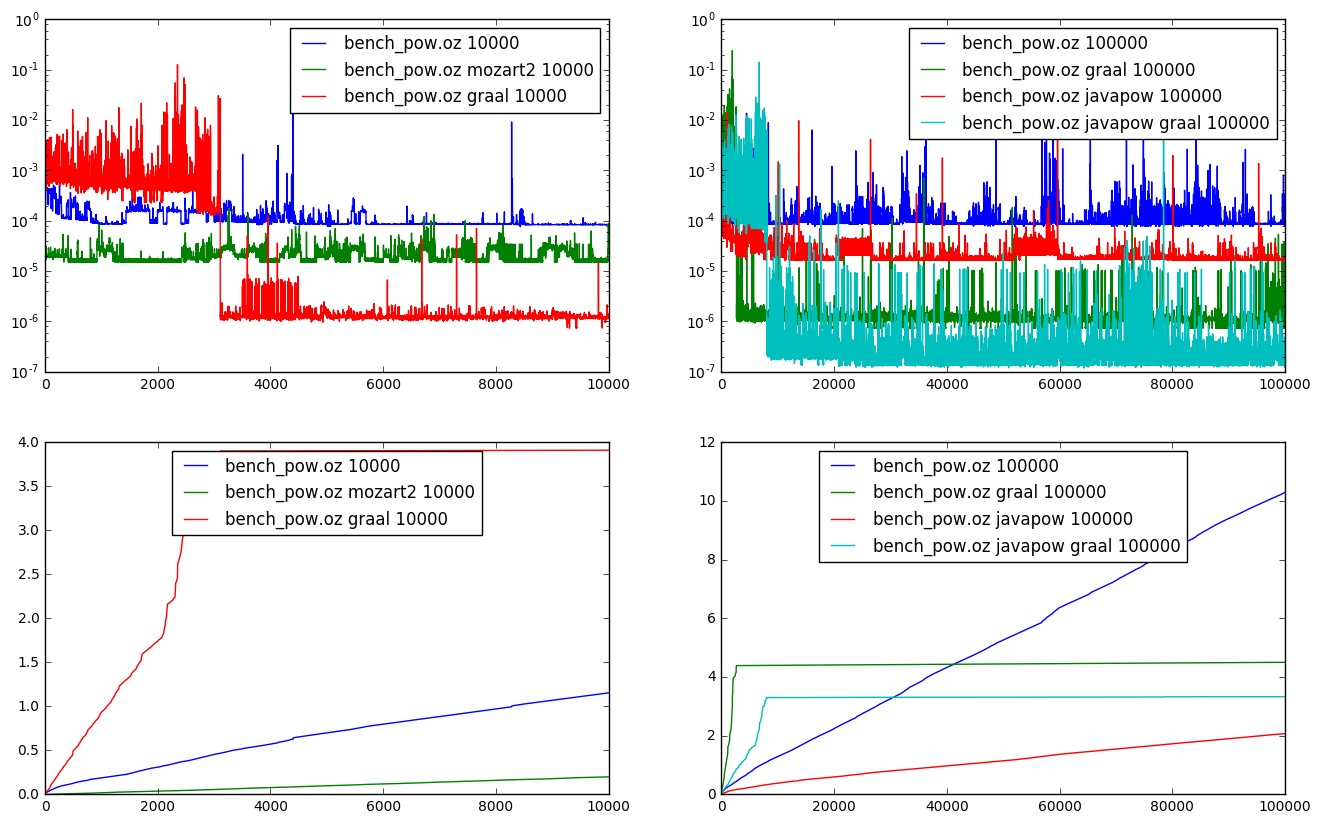

median [  8.69015000e-05   1.72680000e-05   1.28000000e-06]
median [  8.68900000e-05   1.13400000e-06   1.71520000e-05   1.73000000e-07]


In [2]:
medium()

pow_easy, pow_hard = Serie("pow")["10000", "100000"]

pow_easy.sub(221).plot()
pow_easy.sub(223).prog()

pow_hard.sub(222).plot()
pow_hard.sub(224).prog()
plt.show()

print("median", pow_easy.agg(np.median))
print("median", pow_hard.agg(np.median))

## Map

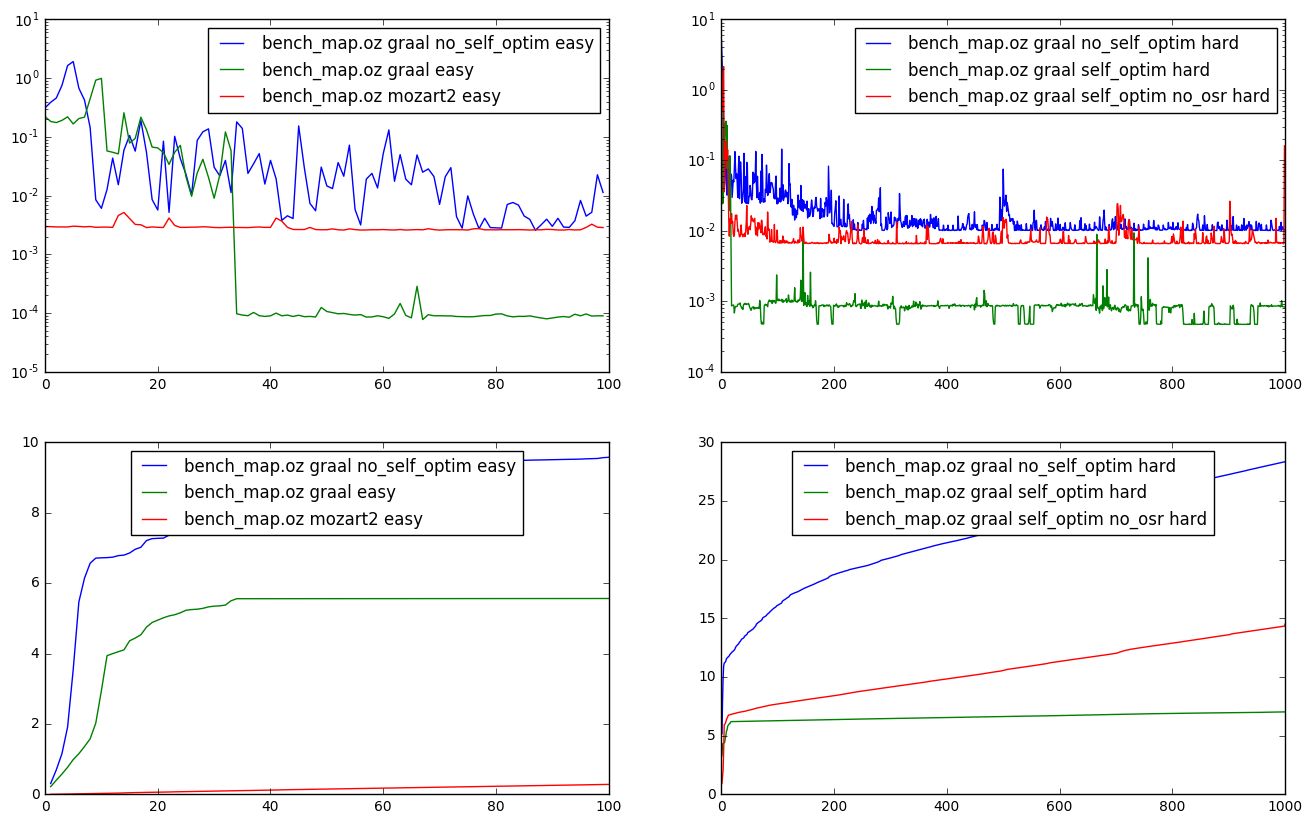

median [  1.90751920e-02   9.42510000e-05   2.73314650e-03]
median [ 0.01138592  0.00086036  0.0067233 ]


In [3]:
medium()

map_easy, map_hard = Serie("map")["easy", "hard"]

map_easy.sub(221).plot()
map_easy.sub(223).prog()

map_hard.sub(222).plot()
map_hard.sub(224).prog()
plt.show()

print("median", map_easy.agg(np.median))
print("median", map_hard.agg(np.median))

## Flatten

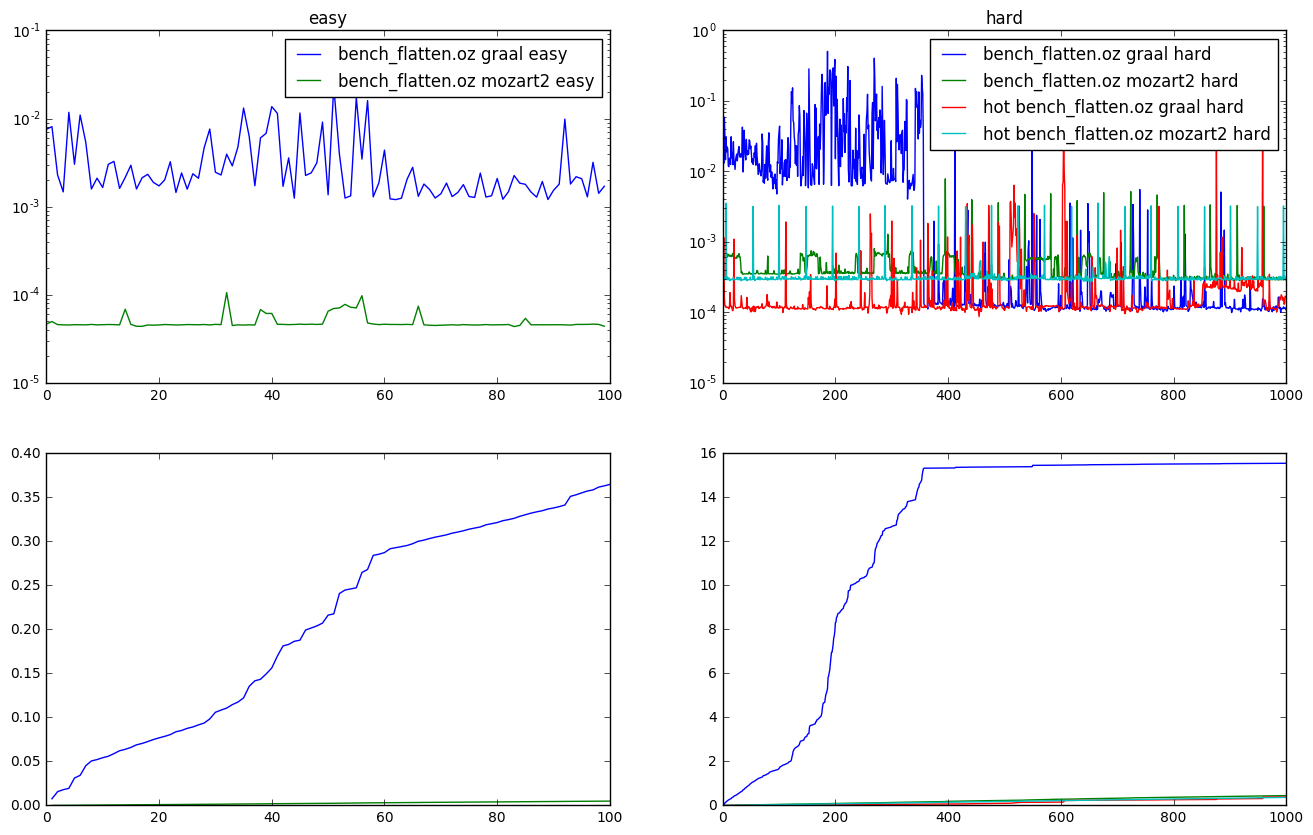

median [  2.07765250e-03   4.56735000e-05]
median [ 0.00013347  0.00035199  0.00011833  0.00029526]


In [4]:
medium()

flatten_easy, flatten_hard = Serie("flatten")["easy", ("hard", "hard_hot")]

flatten_hard = merge(flatten_hard, ["{}", "hot {}"])

flatten_easy.sub(221, title="easy").plot()
flatten_easy.sub(223).prog(legend=None)

flatten_hard.sub(222, title="hard").plot(legend=0)
flatten_hard.sub(224).prog(legend=None)
plt.show()

print("median", flatten_easy.agg(np.median))
print("median", flatten_hard.agg(np.median))

## Project

In [5]:
Serie("project")[""].mat

array([[ 18.0697297 ],
       [ 54.75731435]])

## Cost of measurements

Of course, in the previous graphs, it may have been possible the measure would be non-negligible in some results. Let's plot a no-op benchmark in order to see the order of magnitude

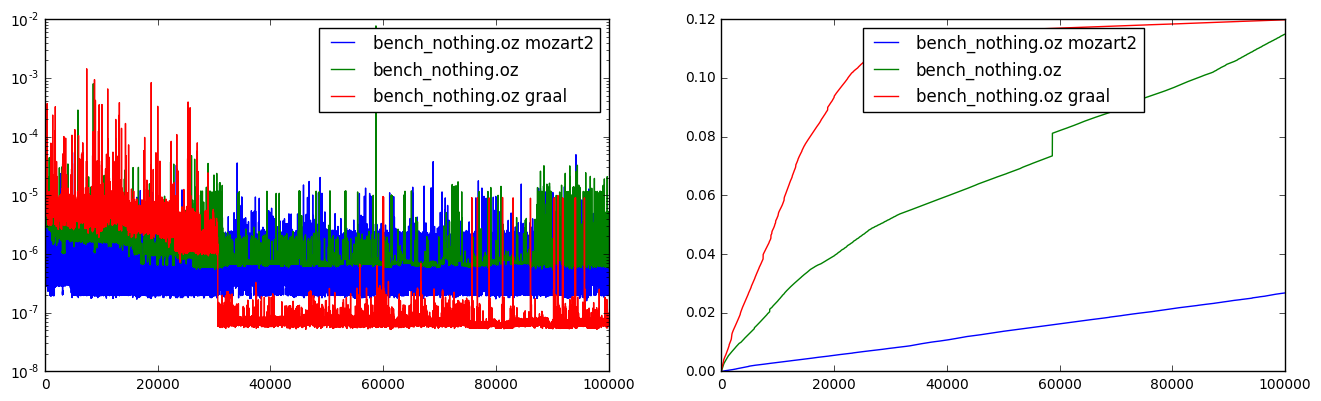

median [  2.16000000e-07   7.15000000e-07   7.20000000e-08]


In [6]:
medium()

nothing = Serie("nothing")["100000"]
nothing.sub(221).plot()
nothing.sub(222).prog()
plt.show()

print("median", nothing.agg(np.median))